In [33]:
import sys
modelkey = 3
sys.argv = [f"--modelversion {modelkey}"]
import multiprocessing

import pandas as pd
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score
from sklearn import utils
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

import config.config as cc
from Functions.original.methods.general.generator import Generator
import torch.nn as nn
import torch
from Functions import metrics
import xgboost as xgb
from sampler import sample
import numpy as np
from itertools import combinations
import Functions.evaluation as ev
import pickle
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from _1_DataPrep import SpecificPrep, CommonPrep

%load_ext autoreload
%autoreload 2

df = fetch_openml(data_id=41214, as_frame=True).data
common = CommonPrep()
train0, _, test0 = common.fit_transform(df)
real = train0, _, test0

cc.metadata_ei = cc.load_metadata(metadata_path='./config/metadata.json')
cc.metadata_noei = cc.load_metadata(metadata_path='./config/metadata_noei.json')

datasets = {
    'ei': SpecificPrep(variables = cc.metadata_ei['variables'], gan_cats = cc.metadata_ei['cats_vars_gan'], xgb_cats = cc.metadata_ei['cats_vars_xgb'], addei=True, columns_to_scale = cc.metadata_ei['standardized_vars']),
    'noei': SpecificPrep(variables = cc.metadata_noei['variables'], gan_cats = cc.metadata_noei['cats_vars_gan'], xgb_cats = cc.metadata_noei['cats_vars_xgb'], addei=False, columns_to_scale = cc.metadata_noei['standardized_vars'])
}

for key, trans in datasets.items():
    train = train0.copy(deep=True)
    test = test0.copy(deep=True)
        
    trans = trans.fit(train)
    train = trans.transform(train)
    test = trans.transform(test)
    
    train = trans.inverse_transform(train)
    test = trans.inverse_transform(test)
    
    datasets[key] = {
        'train': train,
        'test': test,
        'transformer': trans
    }

bestmodels = {
    'H1':   ev.get_model(104, datasets, bestmodel=False), # 22
    'l_ei':   ev.get_model( 22, datasets, bestmodel=False), # 22
    'l_noei': ev.get_model(122, datasets, bestmodel=False),# 104
    's_ei':   ev.get_model(721, datasets, bestmodel=False), # 721
    's_noei': ev.get_model(621, datasets, bestmodel=False) # 621
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



KeyboardInterrupt



In [2]:
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

bestmodels['l_noei']['transformer'].xgb_dummifier.drop_first = False
bestmodels['l_ei']['transformer'].xgb_dummifier.drop_first = False

lei = ev.gan_xgb(metadata=cc.metadata_ei, postprocess=True, testset=test, 
        transformer=datasets['ei']['transformer'], value=bestmodels['l_ei'], seed=1, stratify=False, supersample=True)
lnoei = ev.gan_xgb(metadata=cc.metadata_noei, postprocess=True, testset=test, 
        transformer=datasets['noei']['transformer'], value=bestmodels['l_noei'], seed=1, stratify=False, supersample=True)
lei = undummify(lei)
lnoei = undummify(lnoei)

# preds_s_ei = ev.gan_xgb(metadata=cc.metadata_ei, postprocess=True, testset=datasets['noei']['test'], 
#         transformer=datasets['ei']['transformer'], value=bestmodels['s_ei'], seed=1, stratify=False)
# preds_s_noei = ev.gan_xgb(metadata=cc.metadata_noei, postprocess=True, testset=datasets['noei']['test'], 
#         transformer=datasets['noei']['transformer'], value=bestmodels['s_noei'], seed=1, stratify=False)

In [3]:
real = pd.concat([train0, _, test0])


In [52]:
real['XGBoost built on'] = 'Real data'
lei['XGBoost built on'] = 'GAN: With expert input'
lnoei['XGBoost built on'] = 'GAN: Without exp. inp.'
df4 = pd.concat([real,lei,lnoei])


In [75]:
colname='DrivAge'
df5 = df4.copy(deep=True)[[colname, 'ClaimNb', 'XGBoost built on']]
df5[colname] = df5[colname].astype(int)
minn = df5.loc[df5['XGBoost built on']=='Real data', colname].min()
maxx = df5.loc[df5['XGBoost built on']=='Real data', colname].max()
df5 = df5.loc[df5[colname].between(minn, maxx),:]
df5[colname].min()

-32

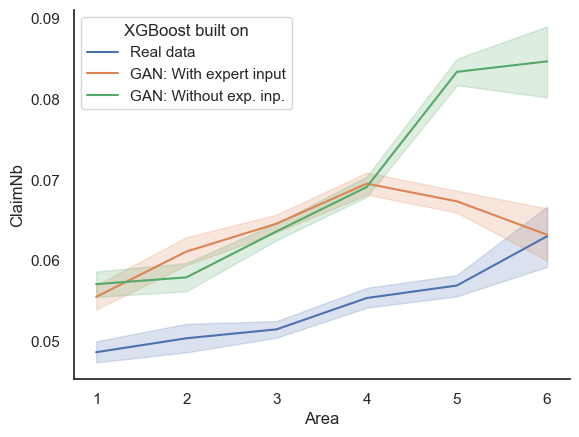

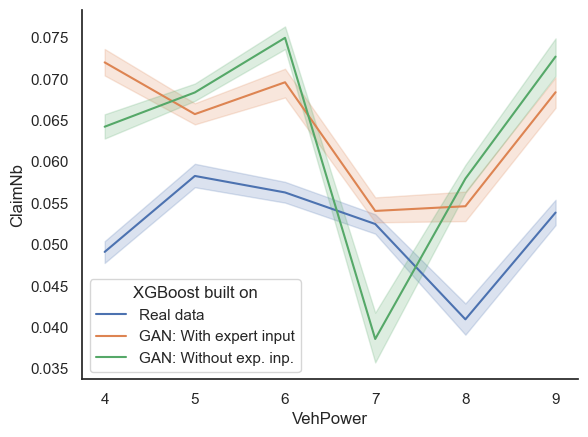

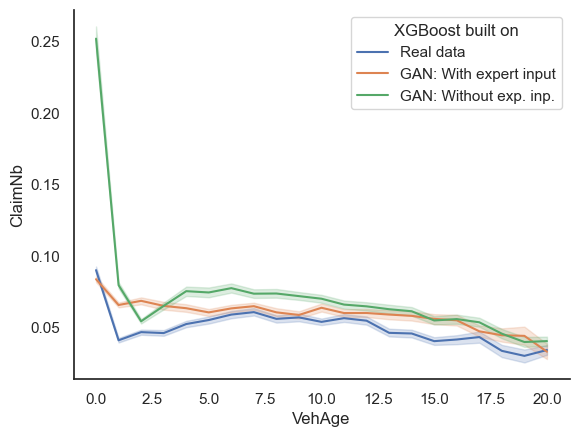

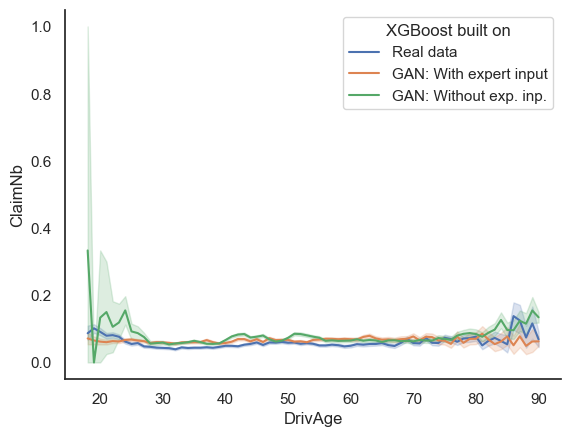

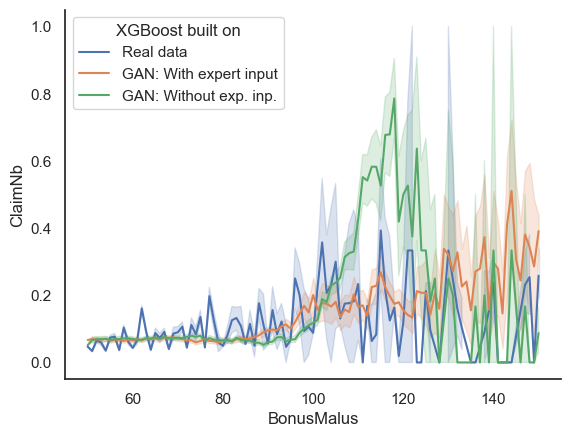

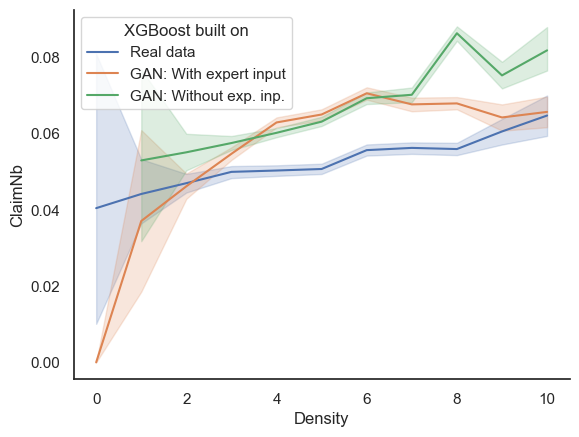

In [78]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", rc=custom_params)
def mylineplot(colname, df4=df4, real=real):
    df5 = df4.copy(deep=True)[[colname, 'ClaimNb', 'XGBoost built on']]
    df5[colname] = df5[colname].astype(int)
    minn = df5.loc[df5['XGBoost built on']=='Real data', colname].min()
    maxx = df5.loc[df5['XGBoost built on']=='Real data', colname].max()
    df5 = df5.loc[df5[colname].astype(int).between(minn, maxx)].round()

    return sns.lineplot(data=df5, x=colname, y='ClaimNb', hue='XGBoost built on', estimator='mean', errorbar=('ci', 95))#, err_style="bars"

for colname in ['Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']:
    mylineplot(colname)
    plt.show()

In [4]:
pd.set_option('display.max_rows', 500)

dfs = [df[['Density', 'VehAge']].round().astype(int).groupby('Density', as_index=False).count() for df in [real, lei, lnoei]]
pd.merge(pd.merge(dfs[0], dfs[1], on='Density', how='outer'), dfs[2], on='Density', how='outer').sort_values('Density').fillna(0).astype(int)

,Density,VehAge_x,VehAge_y,VehAge
0,0,7,3,0
1,1,670,42,20
2,2,14072,3170,1993
3,3,52399,52337,24422
4,4,98522,111364,76354
5,5,120483,122849,191296
6,6,114515,104968,113334
7,7,114171,122256,117583
8,8,112721,101873,100574
9,9,35086,38278,38866


NameError: name 'plt' is not defined

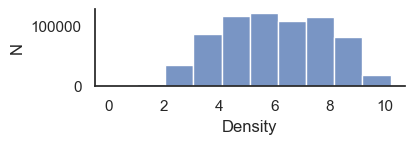

In [24]:
for colname in ['Density']:
    for df in [real, lei, lnoei]:
        df_freq = df
        df_freq = df_freq.sort_values(colname)
        sns.set(rc={'figure.figsize':(4,1)})
        custom_params = {"axes.spines.right": False, "axes.spines.top": False}
        sns.set_theme(style="white", rc=custom_params)
        ax = sns.histplot(df_freq[colname], bins=10)
        ax.set(ylabel='N')
        ax.set(xlabel=colname)
        
        if colname in ['Region', 'VehBrand']:
            plt.xticks(rotation=90)
        plt.show()


In [ ]:
for colname in ['ClaimNb', 'Area', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region']:
    for df in [real, lei, lnoei]:
        df_freq = df
        df_freq = df_freq.sort_values(colname)
        sns.set(rc={'figure.figsize':(4,1)})
        custom_params = {"axes.spines.right": False, "axes.spines.top": False}
        sns.set_theme(style="white", rc=custom_params)
        ax = sns.histplot(df_freq[colname], bins=10)
        ax.set(ylabel='N')
        ax.set(xlabel=colname)
        
        if colname in ['Region', 'VehBrand']:
            plt.xticks(rotation=90)
        plt.show()


[Text(-1000000.0, 0, '-1000000.0'),
 Text(0.0, 0, '0.0'),
 Text(1000000.0, 0, '1000000.0'),
 Text(2000000.0, 0, '2000000.0'),
 Text(3000000.0, 0, '3000000.0'),
 Text(4000000.0, 0, '4000000.0'),
 Text(5000000.0, 0, '5000000.0'),
 Text(6000000.0, 0, '6000000.0'),
 Text(7000000.0, 0, '7000000.0')]

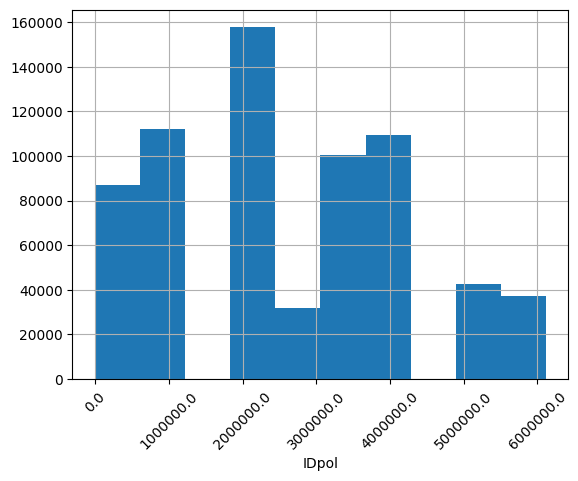

In [101]:
ax = df_freq[colname].hist()
ax.set_xlabel(colname)
ax.set_xticklabels(ax.get_xticks(), rotation = 45)

<Axes: ylabel='Density'>

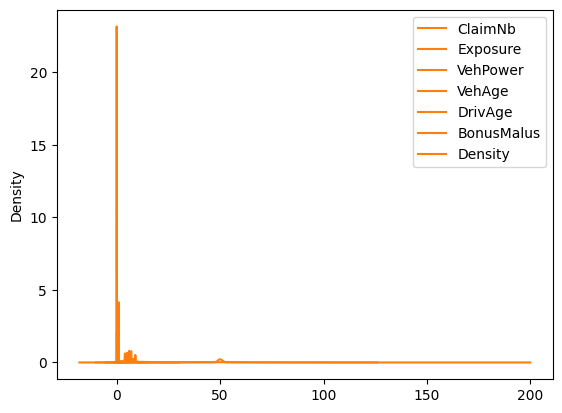

In [47]:
# Distributions of variables
df_freq.drop('IDpol', axis=1).hist(bins= 10, layout=(7, 1), figsize=(4,20))

In [ ]:
df2 = df.groupby(list(df.drop(['IDpol', 'ClaimNb', 'Exposure'], axis=1).columns)).count()

In [ ]:
df2.groupby('IDpol').count()

In [7]:
plt.subplots(nrows=1, ncols=3, figsize=(25, 8))
plt.subplot(1, 3, 1)
sns.histplot(df_freq, x='Exposure')
plt.subplot(1, 3, 2)
sns.boxplot(y="Exposure", data=df_freq)
plt.subplot(1, 3, 3)
sns.histplot(df_freq, x='ClaimNb')
df_freq['ExposureGrp'] = df_freq['Exposure'].apply(lambda x: 'Full Year' if x == 1 else 'not Full Year')
df_freq[['Exposure', 'ExposureGrp']].groupby('ExposureGrp').count().apply(lambda x: 100 * x / float(x.sum()))

12